In [141]:
# general utils
import numpy as np
import pandas as pd

from scipy.stats import uniform, randint
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV

In [142]:
df = pd.read_csv("data/data_pp.csv", index_col=0)

In [140]:
df

,Name,Number_of_Rating,Genre,Price,Description,Updated,Size,Requires_Android,Content_Rating,Offered_By,...,last_update_ln,In_app_Products_Mean,Free_or_Not,Price_Segment,R_mean,G_mean,B_mean,R_std,G_std,B_std
ID,,,,,,,,,,,,,,,,,,,,,
0,Geometry Dash Lite,7227039,Arcade,0.00,Jump and fly your way through danger in this r...,2019-12-11,5.857981,4.0,1,RobTop Games,...,6.802395,0.0,1.0,0.0,109.975656,123.210478,55.596528,117.723707,78.084704,73.268847
1,Fastlane: Road to Revenge,621784,Action,0.00,THEY TOOK YOUR CITY. THEY SHOULD’VE TAKEN YOUR...,2021-08-16,6.523562,4.4,2,Space Ape,...,5.655992,49.5,1.0,0.0,111.865795,123.851474,104.913302,78.302310,87.087182,76.248771
2,Esports Life Tycoon | Manage your esports team,309,Simulation,3.99,Manage your own esports team. Sign up the best...,2021-05-10,5.321928,4.4,1,UPLAY Online,...,5.950643,0.0,0.0,1.0,82.604599,77.480062,129.321636,73.164192,68.286013,71.654148
3,Armello,29305,Board,0.00,Armello is a grand swashbuckling adventure com...,2018-09-24,6.321928,7.0,3,League of Geeks,...,7.202661,14.5,1.0,0.0,112.746250,86.028758,90.288187,66.673900,76.015736,99.019331
4,Adventure Bay - Paradise Farm,6613,Simulation,0.00,Welcome to your very own exotic cove! Adventur...,2022-03-26,7.209453,4.4,1,GAMEGOS,...,4.158883,39.0,1.0,0.0,155.452338,143.225085,110.534599,75.136896,76.572467,81.926992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,Alto's Odyssey,239709,Action,0.00,Just beyond the horizon sits a majestic desert...,2022-03-10,6.303781,5.0,1,Noodlecake,...,4.382027,4.5,1.0,0.0,190.581026,130.275193,147.000008,67.263192,68.645471,65.022294
2365,Trucker Real Wheels - Simulator,36013,Simulation,0.00,"Take on the role of Trucker, transport various...",2022-02-25,6.209453,5.0,3,Feofun Limited,...,4.532599,94.5,1.0,0.0,97.041890,112.535918,131.064537,71.154715,71.054415,79.794227
2366,Random Dice: Wars,17991,Strategy,0.00,"Send your Dice army to WAR! Real-time, simple,...",2022-04-06,7.169925,5.0,1,111%,...,3.970292,49.5,1.0,0.0,192.111551,111.057647,169.903256,55.628818,81.140195,99.499774


# MODELS

## Tokens from pre-trained NLP model for Descriptions

In [217]:
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

[0, 20920, 232, 2]

In [222]:
text1 = "King"
text2 = "Monkey"

In [223]:
# Inference
encoded_input1 = tokenizer(text1)["input_ids"]

encoded_input2 = tokenizer(text2)["input_ids"]

In [224]:
encoded_input1

[0, 21644, 2]

In [225]:
encoded_input2

[0, 17312, 5282, 2]

In [212]:
encoded_input1.shape

AttributeError: 

In [195]:
result = 1 - spatial.distance.cosine(encoded_input1, encoded_input2)
result

ValueError: operands could not be broadcast together with shapes (7,) (8,) 

## Preprocessing

### Columns

In [89]:
# benchamrk features
bm_cols = ["Genre","Price","Size","Requires_Android",
            "Content_Rating","In_app_Products_Min",
            "In_app_Products_Max","num_of_word","avg_num_of_chars",
            "Digital Purchases","In-App Purchases","In-Game Purchases",
            "Shares Info","Shares Location","Users Interact",
            "last_update","last_update_ln","In_app_Products_Mean",
            "Free_or_Not","Price_Segment","R_mean","G_mean","B_mean",
            "target",
            # "Offered_By"
            ]
df_bm = df[bm_cols].copy()

ffnn_cols = ["Genre","Price","Size","Requires_Android",
            "Content_Rating","In_app_Products_Min",
            "In_app_Products_Max","num_of_word","avg_num_of_chars",
            "Digital Purchases","In-App Purchases","In-Game Purchases",
            "Shares Info","Shares Location","Users Interact",
            "last_update","last_update_ln","In_app_Products_Mean",
            "Free_or_Not","Price_Segment","R_mean","G_mean","B_mean",
            "target",
            # "Offered_By",
            ]
df_ffnn = df[ffnn_cols].copy()

df_bm = pd.get_dummies(df_bm, columns=["Genre"])
df_ffnn = pd.get_dummies(df_ffnn, columns=["Genre"])

In [90]:
X_bm = df_bm.drop(columns=["target"])
y_bm = df_bm[["target"]]

X_ffnn = df_ffnn.drop(columns=["target"])
y_ffnn = df_ffnn[["target"]]

### Train-Test ids

In [91]:
from sklearn.model_selection import train_test_split
X_train_bm, X_test_bm, y_train_bm, y_test_bm = train_test_split(X_bm,y_bm,test_size=0.25,random_state=1)
X_train_ffnn, X_test_ffnn, y_train_ffnn, y_test_ffnn = train_test_split(X_ffnn,y_ffnn,test_size=0.25,random_state=1)

### Creating universal Cross Validation

In [92]:
from sklearn.model_selection import KFold

In [93]:
k_cv = KFold(n_splits=5, shuffle=True, random_state=42)

### Scaler

In [94]:
from sklearn.preprocessing import RobustScaler

r_scaler = RobustScaler(quantile_range=(0.55,0.9))

## Benchmark 1) with KNN

In [95]:
from sklearn.neighbors import KNeighborsRegressor

### Hyper Param Search

In [96]:
knn_clf = KNeighborsRegressor()

knn_r_grid = {
    "clf__n_neighbors":[5,10,25,50,80,120]
    }

# knn_r_grid = {
#     "clf__n_neighbors":[60,150,200,300,400]
#     }

# knn_r_grid = {
#     "clf__n_neighbors":[150,160,170,180,190,200]
#     }
# # grids manually altered

knn_pipe = Pipeline([("scaler", r_scaler), ("clf", knn_clf)])
knn_Ser = GridSearchCV(estimator = knn_pipe, param_grid= knn_r_grid, scoring=["neg_mean_squared_error","neg_mean_absolute_percentage_error"], refit="neg_mean_squared_error", cv = k_cv, verbose=2, n_jobs = -1)


In [97]:
knn_Ser.fit(X_train_bm, y_train_bm)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler',
                                        RobustScaler(quantile_range=(0.55,
                                                                     0.9))),
                                       ('clf', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'clf__n_neighbors': [5, 10, 25, 50, 80, 120]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error',
                      'neg_mean_absolute_percentage_error'],
             verbose=2)

In [98]:
knn_cv_scores = (pd.DataFrame(knn_Ser.cv_results_)[["param_clf__n_neighbors","mean_test_neg_mean_absolute_percentage_error"]]).sort_values(by=["mean_test_neg_mean_absolute_percentage_error"], ascending=False)
knn_cv_scores

,param_clf__n_neighbors,mean_test_neg_mean_absolute_percentage_error
2,25,-0.151608
3,50,-0.151854
1,10,-0.152231
4,80,-0.152324
5,120,-0.152526
0,5,-0.159190


## Benchmark 2) Random Forrest Regressor

In [99]:
from sklearn.ensemble import RandomForestRegressor

In [100]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 75, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

criterion = ["squared_error"]
rf_r_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion':criterion,
               'max_samples':uniform(0.7,0.3)}

In [101]:
rf_clf = RandomForestRegressor(n_jobs = -1)
rf_Ser = RandomizedSearchCV(estimator = rf_clf, param_distributions = rf_r_grid, scoring=["neg_mean_squared_error","neg_mean_absolute_percentage_error"], refit="neg_mean_squared_error", cv = k_cv, n_iter = 5, verbose=2, random_state=42, n_jobs = -1)
rf_Ser.fit(X_train_bm, y_train_bm)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\erenk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(n_jobs=-1), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error'],
                                        'max_depth': [10, 16, 23, 29, 36, 42,
                                                      49, 55, 62, 68, 75,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001ED157A6D70>,
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=42, refit='neg_mean_squared_error',
                   scoring=['neg_mean_squared_error',
                            'neg_mean_absolute_percentage_error'],
                   verbose=2)

In [102]:
rf_cv_scores = (pd.DataFrame(rf_Ser.cv_results_)[["mean_test_neg_mean_absolute_percentage_error"]])\
.sort_values(by=["mean_test_neg_mean_absolute_percentage_error"], ascending=False)
rf_cv_scores.head()

,mean_test_neg_mean_absolute_percentage_error
3,-0.127027
0,-0.127655
1,-0.128009
2,-0.128040
4,-0.128061


## Feed Forward Neural Network (created with tabular data's features)

In [104]:
df.head(2)

,Name,Number_of_Rating,Genre,Price,Description,Updated,Size,Requires_Android,Content_Rating,Offered_By,...,last_update_ln,In_app_Products_Mean,Free_or_Not,Price_Segment,R_mean,G_mean,B_mean,R_std,G_std,B_std
ID,,,,,,,,,,,,,,,,,,,,,
0,Geometry Dash Lite,7227039,Arcade,0.0,Jump and fly your way through danger in this r...,2019-12-11,5.857981,4.0,1,RobTop Games,...,6.802395,0.0,1.0,0.0,109.975656,123.210478,55.596528,117.723707,78.084704,73.268847
1,Fastlane: Road to Revenge,621784,Action,0.0,THEY TOOK YOUR CITY. THEY SHOULD’VE TAKEN YOUR...,2021-08-16,6.523562,4.4,2,Space Ape,...,5.655992,49.5,1.0,0.0,111.865795,123.851474,104.913302,78.302310,87.087182,76.248771


In [105]:
'''
from category_encoders import TargetEncoder

# Genre column categorically encoded with its target mean

encoder = TargetEncoder()
X_train['Genre_Encoder'] = encoder.fit_transform(X_train["Genre"],y_train)
X_test['Genre_Encoder'] = encoder.transform(X_test["Genre"],y_test)

X_train.drop(columns="Genre",inplace=True)
X_test.drop(columns="Genre",inplace=True)
'''

'\nfrom category_encoders import TargetEncoder\n\n# Genre column categorically encoded with its target mean\n\nencoder = TargetEncoder()\nX_train[\'Genre_Encoder\'] = encoder.fit_transform(X_train["Genre"],y_train)\nX_test[\'Genre_Encoder\'] = encoder.transform(X_test["Genre"],y_test)\n'

### Scaling

In [128]:
# MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_ffnn_scaled = scaler.fit_transform(X_train_ffnn)
X_test_ffnn_scaled = scaler.transform(X_test_ffnn)

### Model Creation

In [127]:
from tensorflow import keras
from tensorflow import nn

In [137]:
Input_ = keras.Input(shape=(X_train_ffnn_scaled.shape[1],),name="Input Layer")
Hidden1_ = keras.layers.Dense(64, activation=keras.activations.relu,name="Hidden_Layer_1")(Input_)
Dropout1_ = keras.layers.Dropout(0.2)(Hidden1_)
Skip_con_ = keras.layers.concatenate([Input_,Dropout1_])
Hidden2_ = keras.layers.Dense(32, activation=keras.activations.tanh,name="Hidden_Layer_2")(Skip_con_)
Dropout2_ = keras.layers.Dropout(0.1)(Hidden2_)
Output_ = keras.layers.Dense(1, activation=keras.activations.relu, name="Output")(Dropout2_)
ann_clf = keras.Model(inputs=[Input_], outputs=[Output_])
ann_clf.summary()

ann_clf.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.MeanSquaredError() , 
metrics=[keras.metrics.MeanAbsolutePercentageError()])

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss",patience=15)


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input Layer (InputLayer)       [(None, 39)]         0           []                               
                                                                                                  
 Hidden_Layer_1 (Dense)         (None, 64)           2560        ['Input Layer[0][0]']            
                                                                                                  
 dropout_24 (Dropout)           (None, 64)           0           ['Hidden_Layer_1[0][0]']         
                                                                                                  
 concatenate_1 (Concatenate)    (None, 103)          0           ['Input Layer[0][0]',            
                                                                  'dropout_24[0][0]']      

In [138]:
history_ann = ann_clf.fit(X_train_ffnn_scaled,y_train_ffnn,epochs=120,validation_split=0.15,
verbose=2,callbacks=[early_stop],batch_size=128, 
)

Epoch 1/120


12/12 - 1s - loss: 692.6904 - mean_absolute_percentage_error: 96.0149 - val_loss: 645.6347 - val_mean_absolute_percentage_error: 92.0818 - 1s/epoch - 110ms/step
Epoch 2/120
12/12 - 0s - loss: 598.5721 - mean_absolute_percentage_error: 88.7345 - val_loss: 549.2584 - val_mean_absolute_percentage_error: 84.3140 - 76ms/epoch - 6ms/step
Epoch 3/120
12/12 - 0s - loss: 505.7412 - mean_absolute_percentage_error: 80.8417 - val_loss: 459.6536 - val_mean_absolute_percentage_error: 76.3964 - 73ms/epoch - 6ms/step
Epoch 4/120
12/12 - 0s - loss: 425.9725 - mean_absolute_percentage_error: 73.5393 - val_loss: 391.4396 - val_mean_absolute_percentage_error: 69.7986 - 74ms/epoch - 6ms/step
Epoch 5/120
12/12 - 0s - loss: 368.1827 - mean_absolute_percentage_error: 67.6854 - val_loss: 346.7420 - val_mean_absolute_percentage_error: 65.2553 - 88ms/epoch - 7ms/step
Epoch 6/120
12/12 - 0s - loss: 330.6259 - mean_absolute_percentage_error: 63.7332 - val_loss: 317.6205 - val_mean_absolute_percentage_error: 62.120

In [ ]:
# FLEXIBLE MODEL

Normal_Data_Input = tf.keras.Input(shape=(X_train.shape[1],),name="Normal_Data_Input")
Hidden = tf.keras.layers.Dense(128, activation=tf.nn.tanh,name="First_Hidden")(Normal_Data_Input)
Dropout = tf.keras.layers.Dropout(0.2)(Hidden)
Hidden = tf.keras.layers.Dense(64, activation=tf.nn.tanh,name="Second_Hidden")(Dropout)
Dropout = tf.keras.layers.Dropout(0.1)(Hidden)
Hidden = tf.keras.layers.Dense(32, activation=tf.nn.relu,name="Third_Hidden")(Dropout)
output = tf.keras.layers.Dense(1, activation=tf.nn.relu, name="Output")(Hidden)
model = tf.keras.Model(inputs=[Normal_Data_Input], outputs=[output])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Normal_Data_Input (InputLaye [(None, 28)]              0         
_________________________________________________________________
First_Hidden (Dense)         (None, 128)               3712      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
Second_Hidden (Dense)        (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
Third_Hidden (Dense)         (None, 32)                2080      
_________________________________________________________________
Output (Dense)               (None, 1)                 33  

In [ ]:
model.compile(optimizer="adam" , loss = "mse" , metrics=["mape","mae"])

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=50)

history_dnn = model.fit(X_train_scaled,y_train,epochs=1000,validation_split=0.15,verbose=2,callbacks=[early_stop],batch_size=75)

Epoch 1/1000
21/21 - 1s - loss: 628.1520 - mape: 90.9063 - mae: 24.5350 - val_loss: 413.4313 - val_mape: 73.6060 - val_mae: 19.8578
Epoch 2/1000
21/21 - 0s - loss: 257.1401 - mape: 54.4932 - mae: 15.0313 - val_loss: 91.1483 - val_mape: 30.2266 - val_mae: 8.5641
Epoch 3/1000
21/21 - 0s - loss: 49.4649 - mape: 20.7798 - mae: 5.7837 - val_loss: 19.6721 - val_mape: 14.7535 - val_mae: 3.6537
Epoch 4/1000
21/21 - 0s - loss: 24.8432 - mape: 16.5500 - mae: 3.9669 - val_loss: 20.9492 - val_mape: 15.6283 - val_mae: 3.7215
Epoch 5/1000
21/21 - 0s - loss: 24.0267 - mape: 16.0299 - mae: 3.9114 - val_loss: 19.5017 - val_mape: 14.7372 - val_mae: 3.6380
Epoch 6/1000
21/21 - 0s - loss: 23.8340 - mape: 15.8447 - mae: 3.9283 - val_loss: 19.3266 - val_mape: 14.6957 - val_mae: 3.6211
Epoch 7/1000
21/21 - 0s - loss: 23.5658 - mape: 15.7855 - mae: 3.8810 - val_loss: 19.1059 - val_mape: 14.6541 - val_mae: 3.5949
Epoch 8/1000
21/21 - 0s - loss: 23.0435 - mape: 15.5221 - mae: 3.8314 - val_loss: 18.6135 - val_ma

### TEST Scores

In [ ]:
pred_dnn = model.predict(X_test_scaled)

from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error

mse_dnn = mean_squared_error(y_test , pred_dnn)
mape_dnn = mean_absolute_percentage_error(y_test , pred_dnn)
mae_dnn = mean_absolute_error(y_test , pred_dnn)

Scores_df_dnn = pd.DataFrame(index=["Validation","Test"],columns=["mse","mape","mae"])
Scores_df_dnn.loc["Validation",:] = [history_dnn.history["loss"][-1] , history_dnn.history["mape"][-1] , history_dnn.history["mae"][-1]]
Scores_df_dnn.loc["Test",:] = [mse_dnn , mape_dnn*100 , mae_dnn]
Scores_df_dnn.loc["Percentage_Difference",:] = (Scores_df_dnn.loc["Test"] - Scores_df_dnn.loc["Validation"])/Scores_df_dnn.loc["Test"]*100

Scores_df_dnn

,mse,mape,mae
Validation,6.659935,8.047577,2.005603
Test,9.859986,10.382125,2.282136
Percentage_Difference,32.454925,22.486229,12.117279


### Plot

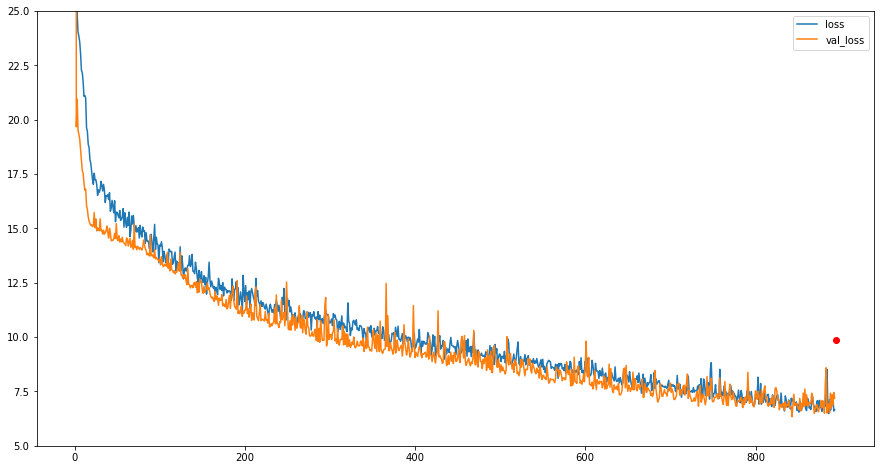

In [ ]:
plt.figure(figsize=(15,8))
history_df = pd.DataFrame(history_dnn.history)
sns.lineplot(data=history_df[["loss","val_loss"]],dashes=False)
plt.scatter(len(history_df) , mse_dnn, marker="o",color = "r")
# plt.xlim(-2,50)
plt.ylim(5,25)

plt.show()

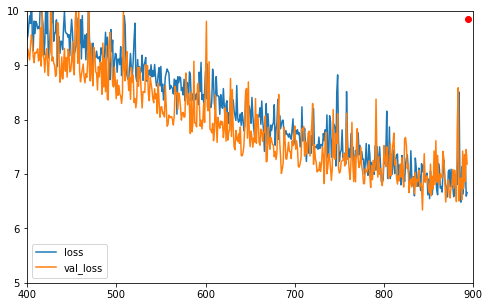

In [ ]:
plt.figure(figsize=(8,5))
history_df = pd.DataFrame(history_dnn.history)
sns.lineplot(data=history_df[["loss","val_loss"]],dashes=False)
plt.scatter(len(history_df) , mse_dnn, marker="o",color = "r")
plt.xlim(400,900)
plt.ylim(5,15)

plt.show()

## CNN MODEL

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

### Splitting CNN's data

In [ ]:
# CNN SPLIT

reduced_size = (28,28) # Images' sizes reduced due to deficiency of computing power

X_train_image = []
for idx in X_train.index:
    current_image = PIL.Image.open(image_df.loc[idx,"full_paths"])
    current_image = current_image.resize(reduced_size)
    arr = np.array(current_image)
    X_train_image.append(arr)

X_train_image = np.array(X_train_image)

X_test_image = []
for idx in X_test.index:
    current_image = PIL.Image.open(image_df.loc[idx,"full_paths"])
    current_image = current_image.resize(reduced_size)
    arr = np.array(current_image)
    X_test_image.append(arr)

X_test_image = np.array(X_test_image)

### Scaling

In [ ]:
X_train_image = X_train_image/255
X_test_image = X_test_image/255

### Model Creation

In [ ]:
X_train_image.shape

(1776, 28, 28, 3)

In [ ]:
inputs = keras.Input(shape = X_train_image.shape[1:])
conv1 = layers.Conv2D(16, kernel_size=(3,3), activation="relu")(inputs)
pool1 = layers.MaxPool2D(pool_size=(2,2))(conv1)
conv2 = layers.Conv2D(8, kernel_size=(3,3), activation="relu")(pool1)
pool2 = layers.MaxPool2D(pool_size=(2,2))(conv2)
flatten = layers.Flatten()(pool2)

x = layers.Dense(64, activation="swish")(flatten)
Dropout = tf.keras.layers.Dropout(0.1)(x)
x = layers.Dense(64, activation="tanh")(Dropout)

outputs = layers.Dense(1, activation="relu")(x)

mdl = keras.Model(inputs = inputs, outputs = outputs)

mdl.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                1286

In [ ]:
mdl.compile(optimizer="adam" , loss = "mse" , metrics=["mape","mae"])

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=25)

history_cnn = mdl.fit(X_train_image,y_train,epochs=10,validation_split=0.15,verbose=1,callbacks=[early_stop])

Epoch 1/10
48/48 [==============================] - 2s 27ms/step - loss: 409.8569 - mape: 70.7403 - mae: 19.3238 - val_loss: 242.1642 - val_mape: 54.2672 - val_mae: 14.8916
Epoch 2/10
48/48 [==============================] - 1s 17ms/step - loss: 208.8163 - mape: 48.6000 - mae: 13.5779 - val_loss: 159.8538 - val_mape: 42.5513 - val_mae: 11.8316
Epoch 3/10
48/48 [==============================] - 1s 16ms/step - loss: 139.4894 - mape: 37.9945 - mae: 10.7861 - val_loss: 105.3470 - val_mape: 32.9629 - val_mae: 9.3000
Epoch 4/10
48/48 [==============================] - 1s 16ms/step - loss: 93.3062 - mape: 29.8310 - mae: 8.5489 - val_loss: 69.4002 - val_mape: 25.3235 - val_mae: 7.2340
Epoch 5/10
48/48 [==============================] - 1s 16ms/step - loss: 63.7597 - mape: 24.0199 - mae: 6.8705 - val_loss: 47.3582 - val_mape: 20.4142 - val_mae: 5.8116
Epoch 6/10
48/48 [==============================] - 1s 17ms/step - loss: 45.6253 - mape: 20.1762 - mae: 5.6860 - val_loss: 34.3058 - val_mape: 1

### TEST Scores

In [ ]:
pred_cnn = mdl.predict(X_test_image)

from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error

mse_cnn = mean_squared_error(y_test , pred_cnn)
mape_cnn = mean_absolute_percentage_error(y_test , pred_cnn)
mae_cnn = mean_absolute_error(y_test , pred_cnn)

Scores_df_cnn = pd.DataFrame(index=["Validation","Test"],columns=["mse","mape","mae"])
Scores_df_cnn.loc["Validation",:] = [history_cnn.history["loss"][-1] , history_cnn.history["mape"][-1] , history_cnn.history["mae"][-1]]
Scores_df_cnn.loc["Test",:] = [mse_cnn , mape_cnn*100 , mae_cnn]
Scores_df_cnn.loc["Percentage_Difference",:] = (Scores_df_cnn.loc["Test"] - Scores_df_cnn.loc["Validation"])/Scores_df_cnn.loc["Test"]*100

Scores_df_cnn

,mse,mape,mae
Validation,25.102423,15.859835,4.038238
Test,27.318265,17.309494,4.183724
Percentage_Difference,8.11121,8.374938,3.477438


### Plot

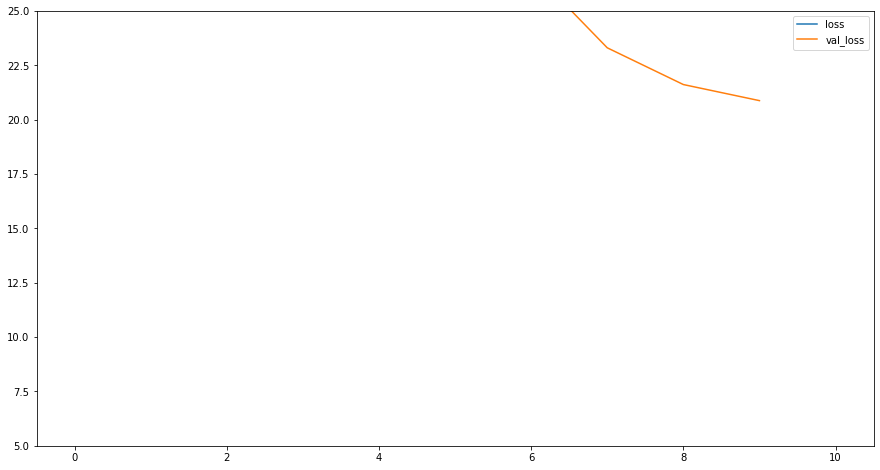

In [ ]:
plt.figure(figsize=(15,8))
history_df = pd.DataFrame(history_cnn.history)
sns.lineplot(data=history_df[["loss","val_loss"]],dashes=False)
plt.scatter(len(history_df) , mse_cnn, marker="o",color = "r")
# plt.xlim(-2,50)
plt.ylim(5,25)

plt.show()

## Downloading NLP's resuls

In [ ]:
lstm_results_train = pd.read_csv("lstm_results_train.csv",index_col=0)
lstm_results_test = pd.read_csv("lstm_results_test.csv",index_col=0)

In [ ]:
lstm_results_train.head()

,target,lstm_result_tr
1681,21.500000,21.713280
1195,29.475468,30.310078
985,16.400000,19.128582
862,20.516292,21.284727
1017,31.485159,29.244856


In [ ]:
lstm_results_test.head()

,target,lstm_result
1094,27.600000,26.112827
188,26.600000,26.355648
1800,32.335674,25.619324
707,23.000000,25.130505
679,28.805571,27.756561


### TEST Scores

In [ ]:
mse_nlp = mean_squared_error(y_test , lstm_results_test["lstm_result"])
mape_nlp = mean_absolute_percentage_error(y_test , lstm_results_test["lstm_result"])
mae_nlp = mean_absolute_error(y_test , lstm_results_test["lstm_result"])

Scores_df_nlp = pd.DataFrame(index=["Test"],columns=["mse","mape","mae"])
Scores_df_nlp.loc["Test",:] = [mse_nlp , mape_nlp*100 , mae_nlp]

Scores_df_nlp

,mse,mape,mae
Test,32.178437,18.770643,4.553034


In [ ]:
mse_nlp = mean_squared_error(y_train , lstm_results_train["lstm_result_tr"])
mse_nlp

# **OVERFIT IN NLP**

4.809008975247715

In [ ]:
Scores_df_nlp

,mse,mape,mae
Test,32.178437,18.770643,4.553034


## Combining **DNN & CNN & NLP**

In [ ]:
dnn_results = model.predict(X_test_scaled)
cnn_results = mdl.predict(X_test_image)
nlp_results = lstm_results_test["lstm_result"].values.reshape(-1,1)

dnn_weight = 0.6
cnn_weight = 0.2
nlp_weight = 0.2

final_results = (dnn_results*dnn_weight) + (cnn_results*cnn_weight) + (nlp_results*nlp_weight)

In [ ]:
dnn_results.shape , cnn_results.shape , nlp_results.shape

((593, 1), (593, 1), (593, 1))

## HYBRID MODEL RESULTS

In [ ]:
mse_hybrid = mean_squared_error(y_test , final_results)
mape_hybrid = mean_absolute_percentage_error(y_test , final_results)
mae_hybrid = mean_absolute_error(y_test , final_results)

Scores_df_hybrid = pd.DataFrame(index=["Test"],columns=["mse","mape","mae"])
Scores_df_hybrid.loc["Test",:] = [mse_hybrid , mape_hybrid*100 , mae_hybrid]

Scores_df_hybrid

,mse,mape,mae
Test,12.771636,11.839032,2.678785


In [ ]:
dnn_arr = Scores_df_dnn.loc["Test",:].values.reshape(1,3)
cnn_arr = Scores_df_cnn.loc["Test",:].values.reshape(1,3)
nlp_arr = Scores_df_nlp.values
hybrid_arr = Scores_df_hybrid.values
full_arr = np.concatenate((dnn_arr,cnn_arr,nlp_arr,hybrid_arr))

In [ ]:
ALL_MODELS_RESULTS = pd.DataFrame(full_arr , index = ["DNN","CNN","NLP","HYBRID"],columns=["mse","mape","mae"])
ALL_MODELS_RESULTS

,mse,mape,mae
DNN,9.859986,10.382125,2.282136
CNN,27.318265,17.309494,4.183724
NLP,32.178437,18.770643,4.553034
HYBRID,12.771636,11.839032,2.678785
